<a href="https://githubtocolab.com/kaust-halo/geeet/blob/master/examples/notebooks/05_TSEB_on_premises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Running the TSEB model locally (on-premises)

Here we apply the TSEB model to the [image asset](https://code.earthengine.google.com/?scriptPath=users%2Flopezvoliver%2Fgeeet%3Atseb_sample_inputs_vis) produced in the previous notebook (`03_prepare_ECMWF_L8_inputs_for_TSEB.ipynb`). 

In contrast to the previous notebook (`04_TSEB_crop_water_use.ipynb`), here we don't run the model in Google Earth Engine: we use the numpy version of the model. 

To do this, the input image asset was exported as a GeoTIFF file and is included in [./data/tseb_sample_inputs.tif](./data/tseb_sample_inputs.tif). The output of the GEE model run was also exported as a GeoTIFF file and we read it here for comparison. 

## Read the input data

The on-premises version of `geeet` works with [numpy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html), which is why `numpy` is the only requirement for `geeet`. However, this notebook requires reading geospatial data and transforming coordinates. 

There are a number of different libraries and packages available for reading geospatial data. In this notebook we use `xarray` (with `rioxarray` as a backend) to read the GeoTIFF file, and then prepare the inputs as numpy arrays for `geeet`. To run the next cell, you will either need to install `xarray` and `rioxarray` or use a different library of your choice to read the GeoTIFF file.  

The sample data is in projected coordinates (UTM zone 37N; EPSG:32637). The TSEB model requires the spatial information in EPSG:4326 (longitude, latitude). Here we use [pyproj](https://pypi.org/project/pyproj/) to perform this transformation. Again, you will either need to install `pyproj` or use a different library of your choice to perform the transformation.

We will also read the output of the GEE run of the same model with the same input data, i.e. the asset created in the [previous notebook](04_TSEB_crop_water_use.ipynb), so we can compare the on-premises and GEE model runs.  

In [1]:
#!pip install xarray rioxarray pyproj   # Uncomment if needed to install xarray, rioxarray, and pyproj
import rioxarray
import xarray as xr
tseb_xrds_mb = rioxarray.open_rasterio('./data/tseb_sample_inputs.tif') # Multi-band data. 

def mb2xds(mb):
    # From multi-band to xarray dataset:
    band_data_list = []
    for band in mb.band.to_numpy():
        band_data = mb[band-1]
        band_data.name = mb.long_name[band-1]
        band_data = band_data.drop('band')
        band_data_list.append(band_data)
    return xr.merge(band_data_list)

tseb_xrds = mb2xds(tseb_xrds_mb)

Tr = tseb_xrds['radiometric_temperature'].data
albedo = tseb_xrds['albedo'].data
NDVI = tseb_xrds['NDVI'].data
P = tseb_xrds['surface_pressure'].data 
Ta = tseb_xrds['air_temperature'].data
U = tseb_xrds['wind_speed'].data
Sdn = tseb_xrds['solar_radiation'].data
Ldn = tseb_xrds['thermal_radiation'].data
# all of these should be a numpy ndarray with size (930, 809). 

xcoord = tseb_xrds['x'].data
ycoord = tseb_xrds['y'].data
import numpy as np
xv, yv = np.meshgrid(xcoord, ycoord, indexing='xy')
# Transform projected coordinates x,y to lon/lat:
from pyproj import Transformer
lat,lon = Transformer.from_crs("epsg:32637", "epsg:4326").transform(xv,yv) 

# Read the GEE-based model run results (from previous notebook)
tsebOut_xrds_mb = rioxarray.open_rasterio('./data/tseb_sample_outputs.tif')
et_tseb_gee = mb2xds(tsebOut_xrds_mb)

## Run the TSEB model (on-premises)

In [2]:
from geeet.tseb import tseb_series
# These are specific to the image we use as an example:
doy = 129 # from asset details. 
time = 10 # from asset details
zT = 2
zU = 10
et_tseb_out = tseb_series(\
    Tr = Tr, Alb = albedo, NDVI = NDVI, P = P, Ta = Ta, U = U, \
    Sdn = Sdn, Ldn = Ldn, doy = doy, time = time, Vza = 0,\
    longitude = lon, latitude = lat, zU = zU, zT = zT)

V:\geeet\geeet\resistances.py:269: RuntimeWarning: divide by zero encountered in true_divide
  RX = (C1/LAI)*((leaf_width/Udzm)**0.5)
V:\geeet\geeet\tseb.py:469: RuntimeWarning: invalid value encountered in multiply
  Tclin = (Ta/ra + Tr/(rs*(1-f_theta)) + (1/ra+1/rs+1/rx)*Hc*rx/(rho*cp))\
V:\geeet\geeet\tseb.py:473: RuntimeWarning: invalid value encountered in multiply
  Td = Tclin*(1+rs/ra) - (1+rs/rx+rs/ra)*Hc*rx/(rho*cp) - Ta*rs/ra


## Compare results with the GEE-model run

Here we make simple [matplotlib](https://matplotlib.org/) plots showing some of the outputs of both model runs. You will need to either install matplotlib, or use another plotting library of your choice. You can also explore the data using any GIS software of your choice. The [sample outputs file](./data/tseb_sample_outputs.tif) corresponds to the data produced with the GEE model run. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def compare_flux(flux_name, cmap = 'viridis', vmin=0, vmax=350):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
    fig.set_figwidth(12)
    fig.set_figheight(5)
    cbar_ax = fig.add_axes([0.9,0.22,0.15,0.5])
    gradient = np.linspace(1,0,256)
    gradient_stack = np.transpose(np.vstack((gradient, gradient)))    
    extent = [0,25,vmin,vmax]
    ax1.imshow(et_tseb_out[flux_name], cmap=cmap, vmin=vmin, vmax=vmax)  # Local model result (this notebook)
    ax1.title.set_text('Local model')
    ax1.margins(0)
    ax2.imshow(et_tseb_gee[flux_name], cmap=cmap, vmin=vmin, vmax=vmax)  # GEE model result (previous notebook)
    ax2.title.set_text('GEE model')
    ax2.margins(0)
    ax3.imshow(np.sqrt((et_tseb_out[flux_name] - et_tseb_gee[flux_name])**2), cmap=cmap, vmin=vmin, vmax=vmax)  # GEE model result (previous notebook)
    ax3.title.set_text('Difference')
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    cbar_ax.imshow(gradient_stack, cmap=cmap, vmin=0, vmax=1, extent=extent)
    cbar_ax.title.set_text('{} ($W/m^2$)'.format(flux_name))
    cbar_ax.get_xaxis().set_visible(False)
    cbar_ax.yaxis.tick_right()
    cbar_ax.margins(0)
    return fig


### Latent heat flux

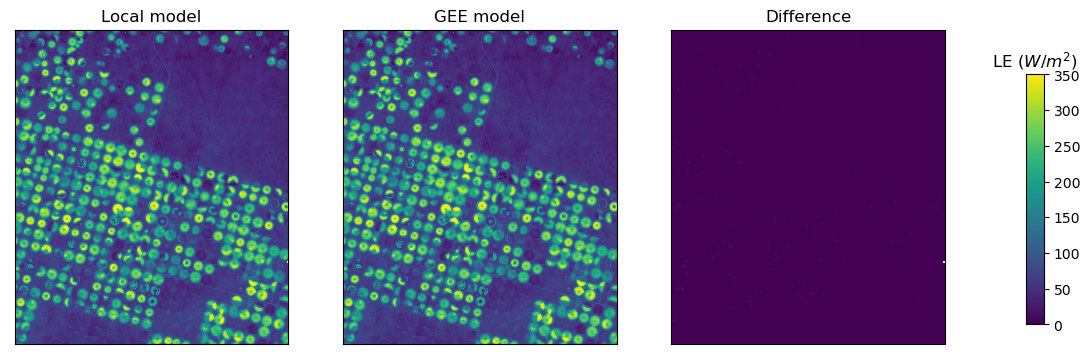

In [4]:
compare_flux('LE')

### Latent heat flux from the canopy component

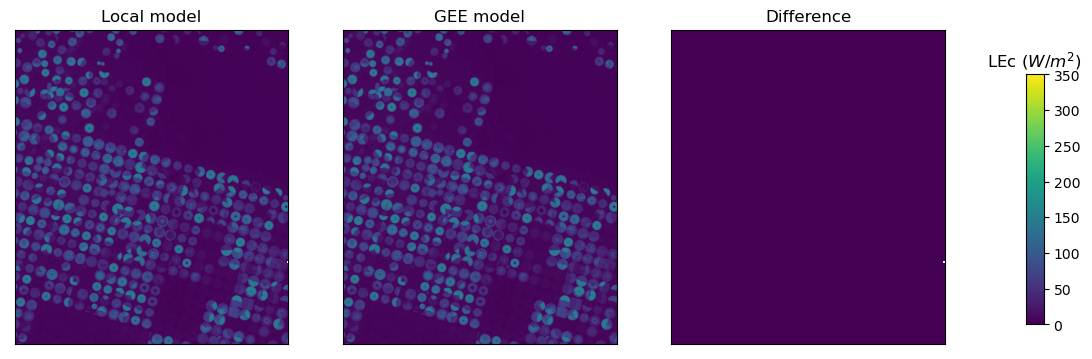

In [5]:
compare_flux('LEc')

### Latent heat flux from the soil component

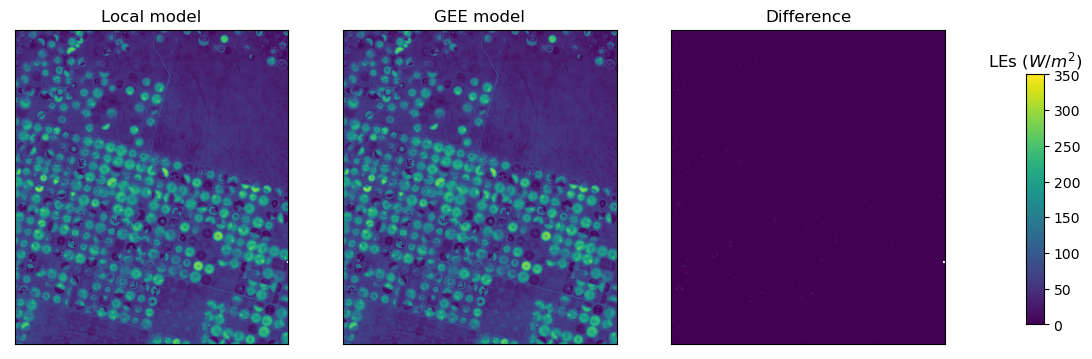

In [6]:
compare_flux('LEs')

### Energy balance closure

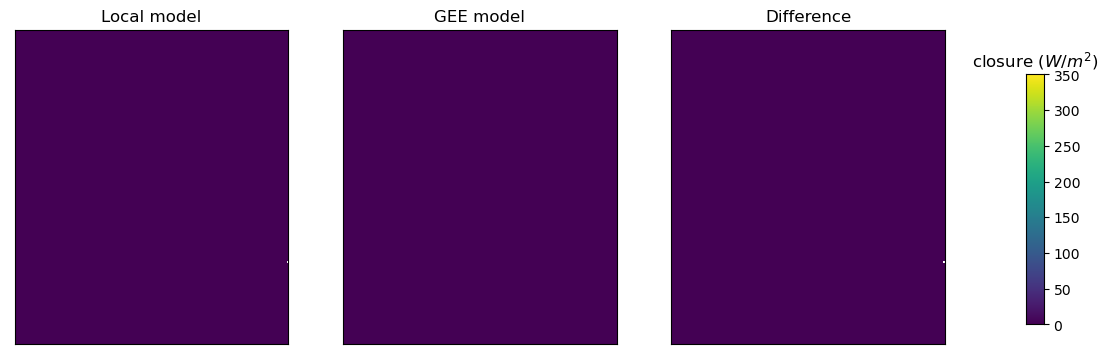

In [7]:
et_tseb_out['closure'] = et_tseb_out['LEs'] + et_tseb_out['LEc'] + et_tseb_out['Hs'] + et_tseb_out['Hc'] + et_tseb_out['G'] - et_tseb_out['Rn']
et_tseb_gee['closure'] = et_tseb_gee['LEs'] + et_tseb_gee['LEc']+ et_tseb_gee['Hs'] + et_tseb_gee['Hc'] + et_tseb_gee['G'] - et_tseb_gee['Rn']
compare_flux('closure')